# **Métodos Avanzados en Aprendizaje Automático**

## Máquinas de Vectores de Soporte

*Autores: Mercedes García Villaescusa y Daniel Beteta Francisco*

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [ ]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [ ]:
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from Utils import plot_dataset_clas, plot_svc
from typing import Tuple
from google.colab import drive


matplotlib.rc('figure', figsize=(15, 5))
SEED = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `sklearn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iterations is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [ ]:
class MySVC():
    
    """
        SVC with a simplified version of SMO.
    """

    def __init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=100) -> None:
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = 'rbf'


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        n_pat = X.shape[0] 
        n_dim = X.shape[1] 

        # Options for gamma (for compatibility with sklean)
        if (self.gamma == "scale"):
            self.gamma = 1.0 / (n_dim * X.var())
        if (self.gamma == "auto"):
            self.gamma = 1.0 / n_dim

        self.a = np.zeros(n_pat) 
        self.X = X
        self.y = y

        for it in range(self.max_iter):
            a_old = np.array(self.a, copy=True)
            for i in range(0, n_pat):
                j = self._choose_j(i)
                ajold = self.a[j]

                d = self.y[j]*(self._E(j)-self._E(i)) / self._kappa(i,j)
                L, H = self._clipping(i, j)

                self.a[j] = min(max(d+ajold, L), H)
                self.a[i] = self.a[i] - self.y[i]*self.y[j]*(self.a[j]-ajold)

            if np.linalg.norm(self.a - a_old) < self.tol:
              break

        self.bounds_sv_ = np.where((self.a > 0) & (self.a < self.C))[0]
        self.support_vectors_ = self.X[self.bounds_sv_]    
        self.b = self._intercept(self.bounds_sv_)


    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return self._compute_with_current_parameters(X) + self.b


    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.sign(self.decision_function(X))


    def _choose_j(self, i: int) -> int:
        np_array_aux = np.arange(len(self.a))
        return np.random.choice(np_array_aux[np_array_aux != i])


    def _E(self, i: int) -> np.ndarray: 
      return self._compute_with_current_parameters(self.X[i][None])[0] - self.y[i]
    

    def _kappa(self, i: int, j: int) -> np.float64:
      return (2*rbf_kernel(self.X[i][None], 
                           self.X[j][None], 
                           self.gamma)[0, 0] - 
                rbf_kernel(self.X[i][None], 
                           self.X[i][None], 
                           self.gamma)[0, 0] -
                rbf_kernel(self.X[j][None], 
                           self.X[j][None], 
                           self.gamma)[0, 0])
          

    def _clipping(self, i: int, j: int) -> Tuple[int, np.float64]:
      if self.y[i] == self.y[j]:
        L = max(0, self.a[j] + self.a[i] - self.C)
        H = min(self.C, self.a[i] + self.a[j])
        return L, H
      else:
        L = max(0, self.a[j] - self.a[i])
        H = min(self.C, self.C - self.a[i] + self.a[j])
        return L, H 
       

    def _intercept(self, k: int) -> np.float64:
      intercept = self.y[k] - self._compute_with_current_parameters(self.X[k])
      # It is averaged for reasons of numerical stability
      return np.mean(intercept)


    def _compute_with_current_parameters(self, X: np.ndarray) -> np.ndarray:
      return (self.a * self.y) @ rbf_kernel(self.X, X, self.gamma)

# Experiments with the SVC

## Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

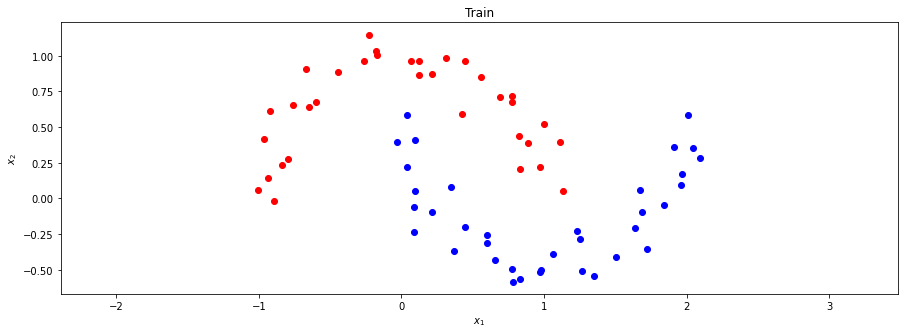

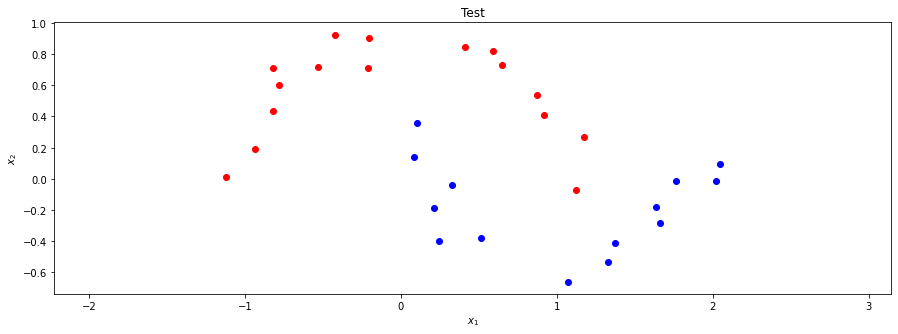

In [ ]:
x, y = make_moons(noise=1e-1, random_state=SEED)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=SEED)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train')
plt.show()

plot_dataset_clas(x_te, y_te)
plt.title('Test')
plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `sklearn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results. If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [ ]:
C = 1
gamma = 'scale'

model_my = MySVC(C=C, gamma=gamma)
model_sk = SVC(C=C, gamma=gamma)

model_my.fit(x_tr,y_tr)
model_sk.fit(x_tr,y_tr)

predict_score_my = model_my.decision_function(x_te)
predict_score_sk = model_sk.decision_function(x_te)

predict_classes_my = model_my.predict(x_te)
predict_classes_sk = model_sk.predict(x_te)

## Comparación de métodos

Vamos primero a comparar si los resultados con ambos métodos son los mismos:

In [ ]:
precision_my = round(len(np.where(y_te == predict_classes_my)[0])/len(y_te), 3)
precision_sk = round(len(np.where(y_te == predict_classes_sk)[0])/len(y_te), 3)
has_same_output = (predict_classes_my==predict_classes_sk).all()

print("Precisión obtenida con nuestra implementación: {}".format(precision_my))
print("Precisión obtenida con la implementación de Sklearn: {}".format(precision_sk))
print("Devuelven la misma clase para todo el conjunto de datos de test: {}".format(has_same_output))

Precisión obtenida con nuestra implementación: 0.967
Precisión obtenida con la implementación de Sklearn: 0.967
Devuelven la misma clase para todo el conjunto de datos de test: True


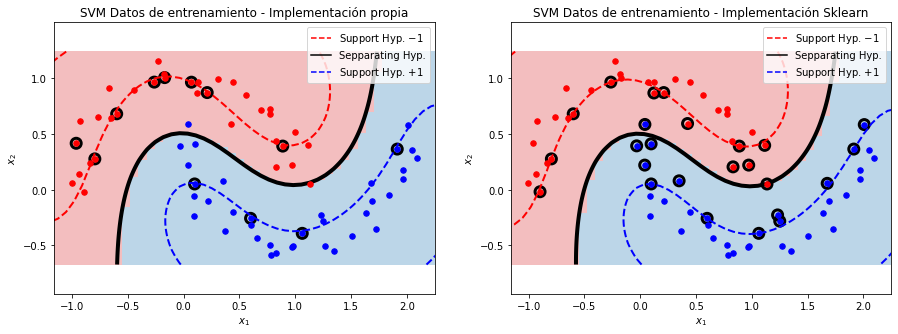

In [ ]:
fig, ax = plt.subplots()

plt.subplot(121)
plot_svc(x_tr, y_tr, model_my)
plt.title("SVM Datos de entrenamiento - Implementación propia")

plt.subplot(122)
plot_svc(x_tr, y_tr, model_sk)
plt.title("SVM Datos de entrenamiento - Implementación Sklearn")

plt.show()

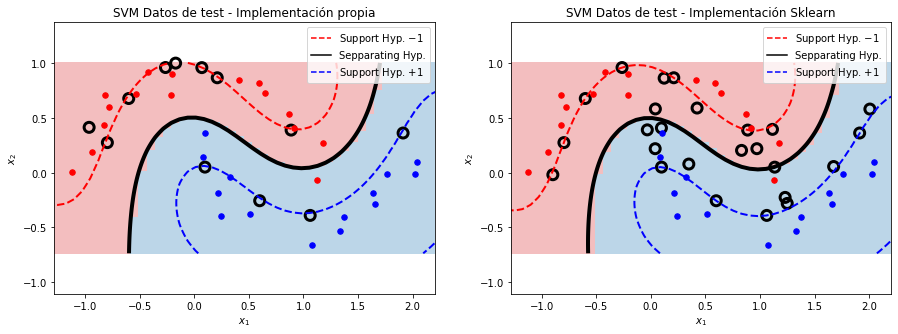

In [ ]:
fig, ax = plt.subplots()

plt.subplot(121)
plot_svc(x_te, y_te, model_my)
plt.title("SVM Datos de test - Implementación propia")

plt.subplot(122)
plot_svc(x_te, y_te, model_sk)
plt.title("SVM Datos de test - Implementación Sklearn")

plt.show()

## Understanding the SVM

### Vectores soporte

Los vectores de soporte son los puntos que definen el margen máximo de separación del hiperplano que separa las clases. 

Dichos puntos se eligen teniendo en cuenta que su $\alpha$ se halle en el rango de valores $(0,C)$. En el caso de que su $\alpha$ sea 0, signfinica que dicho punto se encuentra en su clase correspondiente. Y en el caso de que su $\alpha$ sea C, significa que dicho punto se encuentra fuera del hiperplano de soporte correspondiente y puede estar bien clasificado o no.


 Alpha de los vectores soporte: 
 [6.88792523e-01 4.53456081e-01 2.85734011e-01 2.17915830e-01
 1.11022302e-16 1.06417377e-01 7.58209703e-01 3.41412686e-03
 1.98523099e-01 8.20814290e-01 5.97891904e-01 2.16957100e-01]

 Vectores soporte: 
 [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.09841814  0.05019174]
 [ 1.06252195 -0.39226767]
 [-0.9623992   0.41442543]
 [ 0.06999164  0.96156857]
 [ 0.88775478  0.38926482]
 [-0.1701044   1.00266984]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 1.91345677  0.3625312 ]]


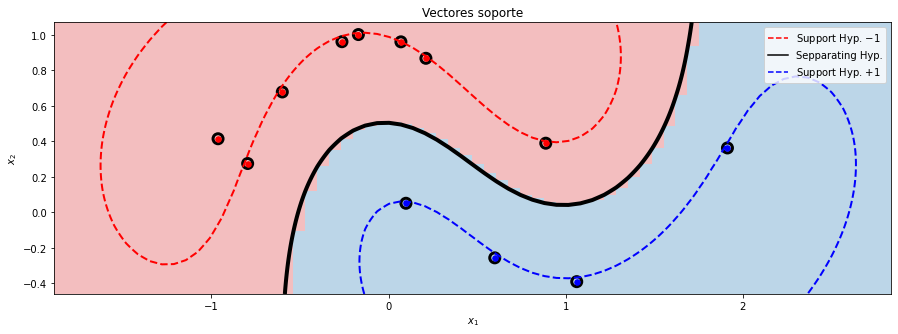

In [ ]:
print('\n Alpha de los vectores soporte: \n', model_my.a[model_my.bounds_sv_])
print('\n Vectores soporte: \n', model_my.support_vectors_)

plot_svc(x_tr[model_my.bounds_sv_], y_tr[model_my.bounds_sv_], model_my)
plt.title("Vectores soporte")
plt.show()

### Puntos mal clasificados

Para encontrar los puntos mal y bien clasificados se compara las predicción de las clases del modelo con las clases de los datos reales de entrenamiento.

In [ ]:
data_training_predictions = model_my.predict(x_tr)

well_clasified_indexes = np.where(y_tr == data_training_predictions)[0]
print("Lista de los puntos de entrenamiento bien clasificados: \n", x_tr[well_clasified_indexes])

bad_clasified_indexes = np.where(y_tr != data_training_predictions)[0]
print("\n Lista de los puntos de entrenamiento mal clasificados: \n", x_tr[bad_clasified_indexes])

print("\nPorcentaje de éxito en el entrenamiento: {}".format(round(len(well_clasified_indexes)/len(y_tr), 3)))
print("Porcentaje de fracaso en el entrenamiento: {}".format(round(len(bad_clasified_indexes)/len(y_tr), 3)))

Lista de los puntos de entrenamiento bien clasificados: 
 [[ 1.68792426 -0.0981035 ]
 [-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.9720389   0.21902698]
 [ 0.65462368 -0.43432386]
 [ 1.26610851 -0.50682361]
 [ 0.09841814  0.05019174]
 [ 0.56155158  0.85122387]
 [ 0.42448524  0.59130712]
 [ 1.06252195 -0.39226767]
 [-0.66625776  0.90611844]
 [-0.1785632   1.03583077]
 [ 2.04744488  0.35091483]
 [-0.9623992   0.41442543]
 [ 0.83169282 -0.56838816]
 [ 0.82483944  0.43424825]
 [ 0.44598685 -0.20238606]
 [-0.92514894  0.61051612]
 [ 0.06999164  0.96156857]
 [ 0.88775478  0.38926482]
 [ 1.23082636 -0.22735139]
 [ 1.63556454 -0.20700992]
 [-0.1701044   1.00266984]
 [ 0.96998002 -0.5188826 ]
 [ 1.115151    0.39583904]
 [ 1.96456314  0.09457656]
 [ 0.12278879  0.8649236 ]
 [-0.22651016  1.14840109]
 [ 0.21729751 -0.09860236]
 [-0.8367634   0.23609495]
 [ 1.67526518  0.05558455]
 [ 0.09103819 -0.06146458]
 [ 0.09012959 -0.23445768]
 [ 0.44663896  0.96634251]
 [ 0.21104358  0.8686439

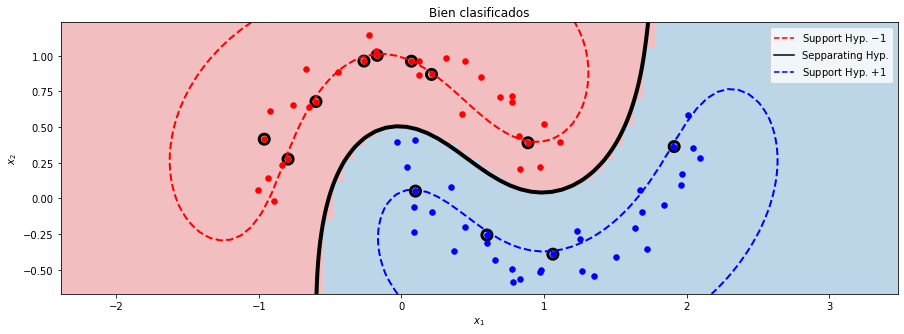

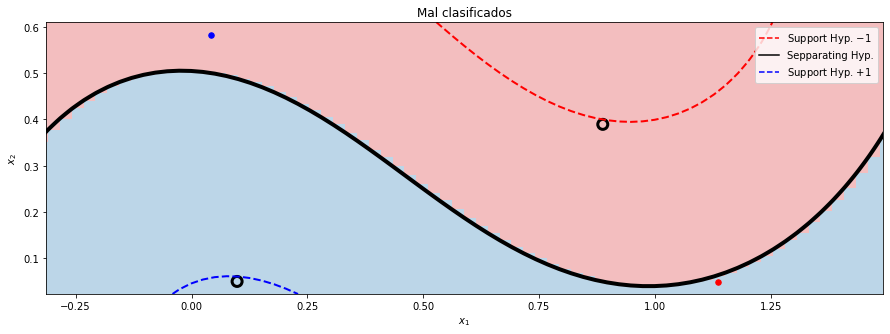

In [ ]:
plot_svc(x_tr[well_clasified_indexes], y_tr[well_clasified_indexes], model_my)
plt.title("Bien clasificados")
plt.show()

plot_svc(x_tr[bad_clasified_indexes], y_tr[bad_clasified_indexes], model_my)
plt.title("Mal clasificados")
plt.show()

Vemos que sólmanete hay dos puntos que están mal clasificados. Los huecos de la gráfica inferior se debe a como está definida la función plot_svc, siendo estos los puntos que representan los vectores soporte.

### Puntos sobre los hiperplanos de soporte

In [ ]:
a_indexes_in_range = np.where((model_my.a > 0) & (model_my.a < C))[0]
print('Lista de puntos de entrenamiento que están sobre los hiperplanos de soporte: \n', x_tr[a_indexes_in_range])

Lista de puntos de entrenamiento que están sobre los hiperplanos de soporte: 
 [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.09841814  0.05019174]
 [ 1.06252195 -0.39226767]
 [-0.9623992   0.41442543]
 [ 0.06999164  0.96156857]
 [ 0.88775478  0.38926482]
 [-0.1701044   1.00266984]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 1.91345677  0.3625312 ]]


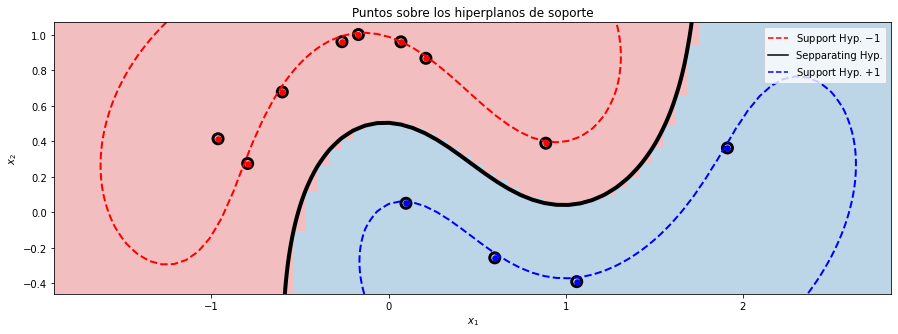

In [ ]:
plot_svc(x_tr[a_indexes_in_range], y_tr[a_indexes_in_range], model_my)
plt.title("Puntos sobre los hiperplanos de soporte")
plt.show()

In [ ]:
are_the_same_points = (x_tr[a_indexes_in_range]==model_my.support_vectors_).all()
print("¿Coinciden los puntos de vectores de soporte con los extraídos bajo la condicición dada? {}".format(are_the_same_points))

¿Coinciden los puntos de vectores de soporte con los extraídos bajo la condicición dada? True


Vemos que estos puntos son los vectores soporte, ya que como habíamos explicado previamente la $\alpha$ de dichos puntos debe estar en el rango de valores $(0,C)$.

### Datos ubicados en el lado incorrecto de los hiperplanos de apoyo pero bien clasificados

In [ ]:
a_indexes_in_c = np.where(model_my.a == C)[0]
print('Lista de puntos de entrenamiento fuera del hiperplano de soporte: \n', x_tr[a_indexes_in_c])

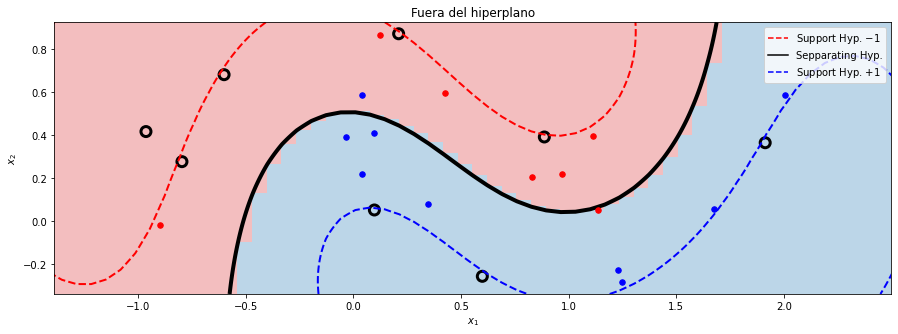

In [ ]:
plot_svc(x_tr[a_indexes_in_c], y_tr[a_indexes_in_c], model_my)
plt.title("Fuera del hiperplano")
plt.show()

In [ ]:
a_indexes_in_c_well_classified = a_indexes_in_c[np.where(model_my.predict(x_tr[a_indexes_in_c]) == y_tr[a_indexes_in_c])[0]]
print('Lista de puntos de entrenamiento fuera del hiperplano de soporte pero bien clasificados: \n', x_tr[a_indexes_in_c])

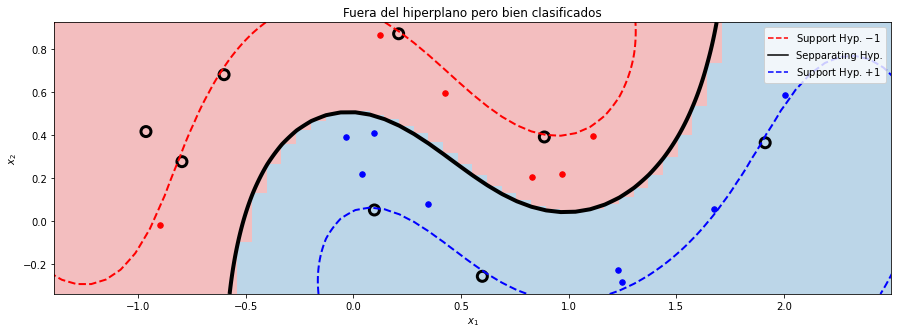

In [ ]:
plot_svc(x_tr[a_indexes_in_c_well_classified], y_tr[a_indexes_in_c_well_classified], model_my)
plt.title("Fuera del hiperplano pero bien clasificados")
plt.show()

Vemos que estos puntos son los que están fuera del hiperplano de soporte, ya que como habíamos explicado previamente los puntos cuya $\alpha$ sea C se encuentran fuera del hiperplano de soporte correspondiente y puede estar bien clasificados o no. Y gracias a la segunda condición aplicada, dichos puntos están bien clasificados.